In [4]:
# --- Spark Bootstrap and Library Setup ---
!apt -qq update -y > /dev/null
!apt -qq install -y openjdk-17-jdk-headless > /dev/null
!pip -q install pyspark==3.5.1 datasets matplotlib seaborn

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# --- Spark Environment Configuration ---
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

# --- Initialize Spark Session ---
spark = (
    SparkSession.builder
    .appName("apps-dataset-analysis")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")

print("✨ Spark Session and Libraries are ready!")



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


✨ Spark Session and Libraries are ready!


In [5]:
# ====================================================================
# HIGHLIGHT: Data extraction
# Here, we connect to the source (Hugging Face Hub) and load the raw
# dataset into our Spark environment.
# ====================================================================
from datasets import load_dataset

try:
    print("Attempting to load 'codeparrot/apps' directly...")
    apps_dataset = load_dataset("codeparrot/apps", split="train")
    df_pandas = apps_dataset.to_pandas()
    df = spark.createDataFrame(df_pandas)
    print("✅ Successfully loaded dataset directly.")

except RuntimeError as e:
    print(f"⚠️ Direct loading failed. This is common in newer library versions.")
    print("Switching to the recommended workaround (loading raw JSONL)...")
    apps_dataset = load_dataset("json", data_files="https://huggingface.co/datasets/codeparrot/apps/resolve/main/train.jsonl", split="train")
    df_pandas = apps_dataset.to_pandas()
    df = spark.createDataFrame(df_pandas)
    df = df.withColumnRenamed("id", "problem_id")
    print("✅ Workaround successful. Columns now match the official schema.")


df.printSchema()

Attempting to load 'codeparrot/apps' directly...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

apps.py: 0.00B [00:00, ?B/s]

⚠️ Direct loading failed. This is common in newer library versions.
Switching to the recommended workaround (loading raw JSONL)...


train.jsonl:   0%|          | 0.00/107M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

✅ Workaround successful. Columns now match the official schema.
root
 |-- problem_id: long (nullable = true)
 |-- question: string (nullable = true)
 |-- solutions: string (nullable = true)
 |-- input_output: string (nullable = true)
 |-- difficulty: string (nullable = true)
 |-- url: string (nullable = true)
 |-- starter_code: string (nullable = true)



In [6]:
# ====================================================================
# HIGHLIGHT: Data cleaning
# This step ensures data quality. Here, we check for and remove any
# duplicate problems based on 'problem_id' to prevent skewed analysis.
# ====================================================================
print(f"Number of rows before cleaning: {df.count()}")
df_cleaned = df.dropDuplicates(['problem_id'])
print(f"Number of rows after cleaning: {df_cleaned.count()}")

Number of rows before cleaning: 5000
Number of rows after cleaning: 5000


In [7]:
# ====================================================================
# HIGHLIGHT: Exploratory Data Analysis (stats, plots, insights)
# We begin EDA by creating new, insightful features from existing data.
# Here, we calculate the character length of questions and solutions.
# ====================================================================

# Calculate the length of the question and solutions strings
df_with_lengths = df_cleaned.withColumn("question_length", F.length(F.col("question"))) \
                             .withColumn("solutions_length", F.length(F.col("solutions")))

print("DataFrame with new length features:")
df_with_lengths.select("problem_id", "difficulty", "question_length", "solutions_length").show(10)

DataFrame with new length features:
+----------+----------+---------------+----------------+
|problem_id|difficulty|question_length|solutions_length|
+----------+----------+---------------+----------------+
|         0| interview|           2599|            7488|
|         1| interview|           2109|           11766|
|         5| interview|           2019|            9925|
|         6| interview|           2705|            6332|
|         7| interview|           2253|            7221|
|         9| interview|           1491|           11078|
|        10| interview|           1892|            7495|
|        17| interview|            999|            3281|
|        19| interview|           2557|           16421|
|        22| interview|           1589|           12755|
+----------+----------+---------------+----------------+
only showing top 10 rows



Distribution of Problem Difficulty:
+------------+-----+
|  difficulty|count|
+------------+-----+
|introductory| 2639|
|   interview| 2000|
| competition|  361|
+------------+-----+



/tmp/ipython-input-687044275.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="difficulty", y="count", data=difficulty_pd, palette="viridis")


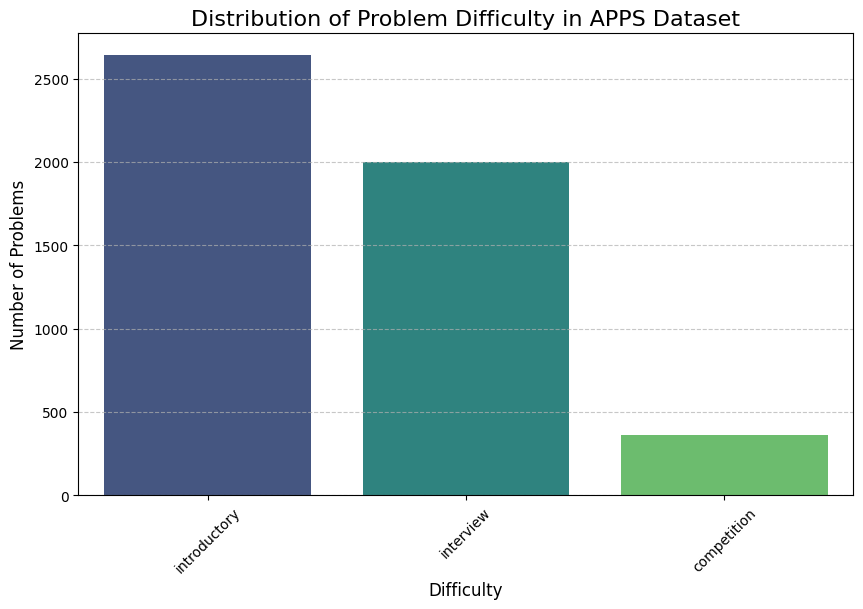

In [8]:
# ====================================================================
# HIGHLIGHT: Exploratory Data Analysis (stats, plots, insights)
# Now we generate statistics and plots. This first plot shows the
# distribution of problems across difficulty levels.
# ====================================================================
difficulty_dist = df_with_lengths.groupBy("difficulty").count().orderBy(F.col("count").desc())

print("Distribution of Problem Difficulty:")
difficulty_dist.show()

# Convert to Pandas for plotting (CORRECTED TYPO HERE)
difficulty_pd = difficulty_dist.toPandas()

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x="difficulty", y="count", data=difficulty_pd, palette="viridis")
plt.title('Distribution of Problem Difficulty in APPS Dataset', fontsize=16)
plt.xlabel('Difficulty', fontsize=12)
plt.ylabel('Number of Problems', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

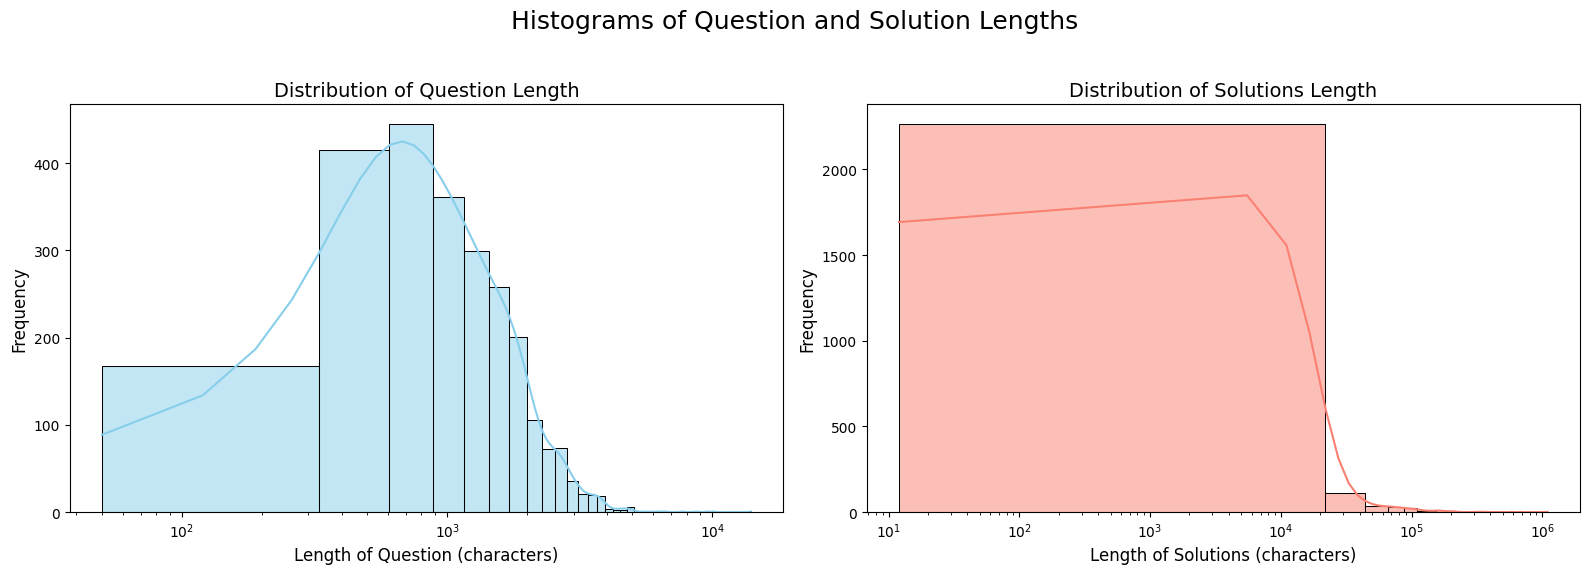

In [9]:
# ====================================================================
# HIGHLIGHT: Exploratory Data Analysis (stats, plots, insights)
# This final EDA step visualizes the distribution of our engineered
# features (question and solution lengths) to understand their spread.
# ====================================================================
plot_data_pd = df_with_lengths.select("question_length", "solutions_length").sample(fraction=0.5, seed=42).toPandas()

# Create the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Question Length
sns.histplot(plot_data_pd['question_length'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Question Length', fontsize=14)
axes[0].set_xlabel('Length of Question (characters)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_xscale('log')

# Plot for Solution Length
sns.histplot(plot_data_pd['solutions_length'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Solutions Length', fontsize=14)
axes[1].set_xlabel('Length of Solutions (characters)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_xscale('log')

plt.suptitle('Histograms of Question and Solution Lengths', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Stop the Spark session
spark.stop()